# <center><ins>REIT Time Series Analysis(Ticker: PLD)<ins/><center/>

In [1]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg

import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

In [2]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

In [3]:
PLD = web.DataReader('PLD', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
PLD = PLD.copy()
PLD.to_csv('data/PLD')
PLD.index = pd.to_datetime(PLD.index)
PLD = PLD.resample('MS').mean()
PLD['mid'] = (PLD['high']+PLD['low'])/2
PLD.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

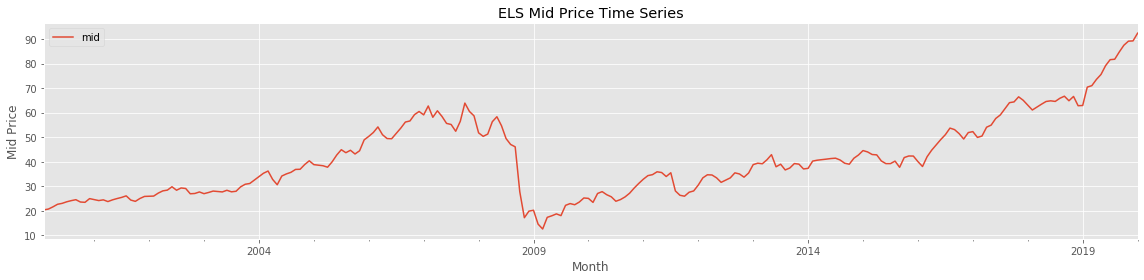

In [4]:
plt.style.use('ggplot')
PLD.plot(figsize = (16,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('ELS Mid Price Time Series')
plt.tight_layout()
plt.show();

## <ins>Time Series Decomposition<ins/>

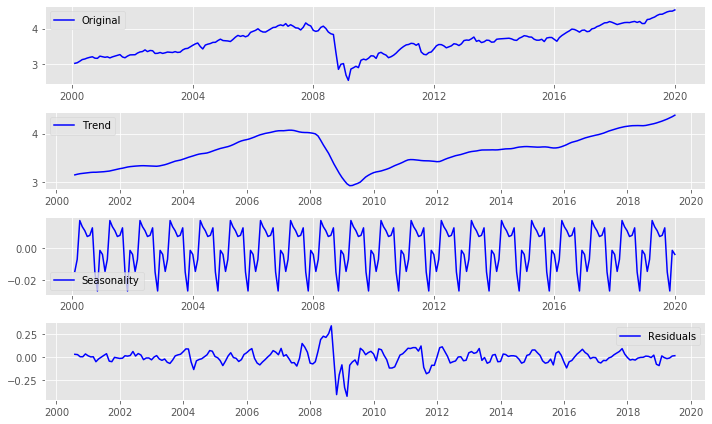

In [5]:
decomposition(PLD)

In [6]:
PLD_diff = PLD.diff(periods = 1).dropna()

In [7]:
dickey_fuller(PLD_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 2.125252343917822e-22


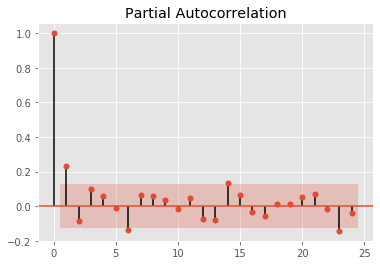

In [8]:
plot_pacf(PLD_diff);

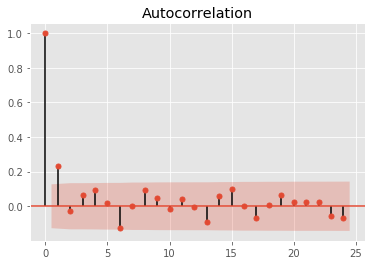

In [9]:
plot_acf(PLD_diff);

In [10]:
parameters = (2,1,5)
seasonal_parameters = (2,1,5,12)

In [11]:
PLD_train = PLD[:'2017']
PLD_test = PLD['2018':]

## <ins>SARIMAX Model w/o Exogenous Variables<ins/>

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(2, 1, 5)x(2, 1, 5, 12)   Log Likelihood                -335.694
Date:                            Thu, 13 Feb 2020   AIC                            703.387
Time:                                    11:16:54   BIC                            749.990
Sample:                                02-01-2000   HQIC                           722.326
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0008      0.004      0.185      0.853      -0.007       0.009
ar.L1         -0.3502     

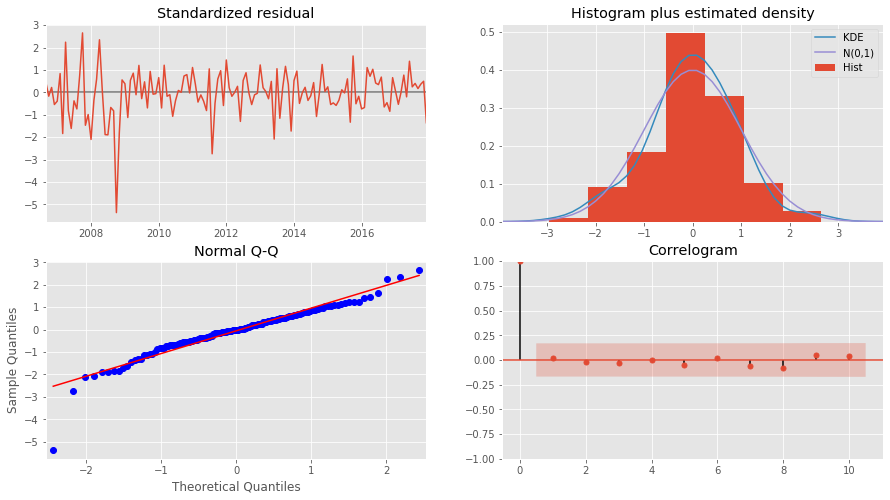

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


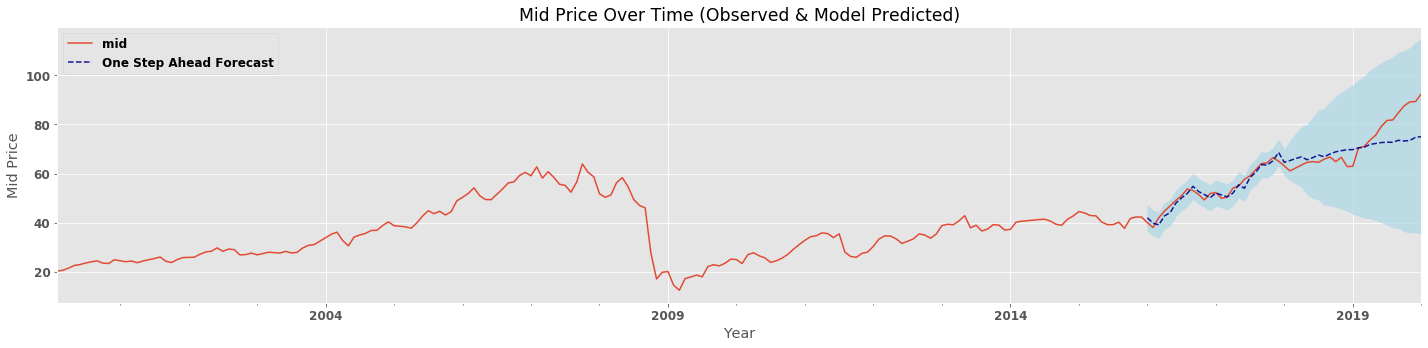

In [12]:
arima_endog(PLD_train, PLD, parameters, seasonal_parameters)

## <ins>Determine Exogenous Feature Importance<ins/>

In [13]:
PLD_rates = pd.read_csv('data/PLD_rates.csv', index_col = 'date')

The R-score of the Lasso Regression is: 0.9840421603036983



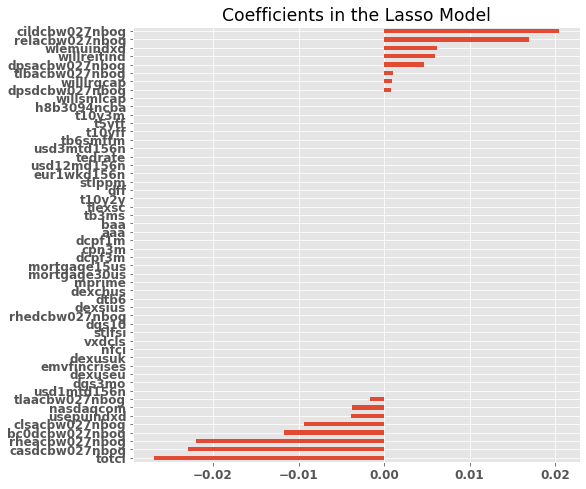

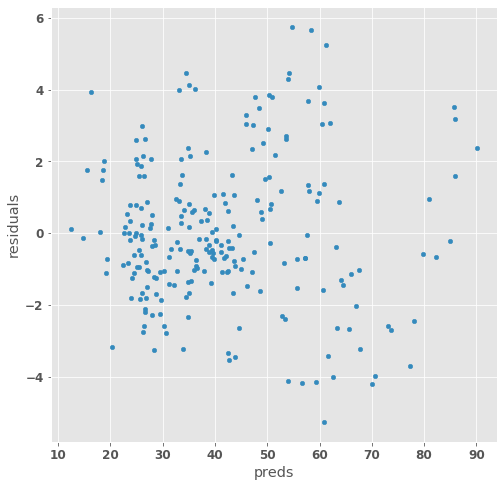

In [14]:
lasso_reg(PLD_rates)

In [15]:
PLD_rates_train = PLD_rates[:'2018']
PLD_rates_test = PLD_rates['2018':]

In [16]:
exog_train = PLD_rates_train[['cildcbw027nbog', 'relacbw027nbog', 'totci', 'casdcbw027nbog', 'rheacbw027nbog']]

In [17]:
exog_test = PLD_rates_test[['cildcbw027nbog', 'relacbw027nbog', 'totci', 'casdcbw027nbog', 'rheacbw027nbog']]

## <ins> SARIMAX Model w/ Exogenous Variables<ins/>

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(2, 1, 5)x(2, 1, 5, 12)   Log Likelihood                -322.484
Date:                            Thu, 13 Feb 2020   AIC                            686.967
Time:                                    11:18:24   BIC                            748.133
Sample:                                02-01-2000   HQIC                           711.824
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift             -0.0050      0.002     -2.218      0.027      -0.009      -0.001
cildcbw027nbog

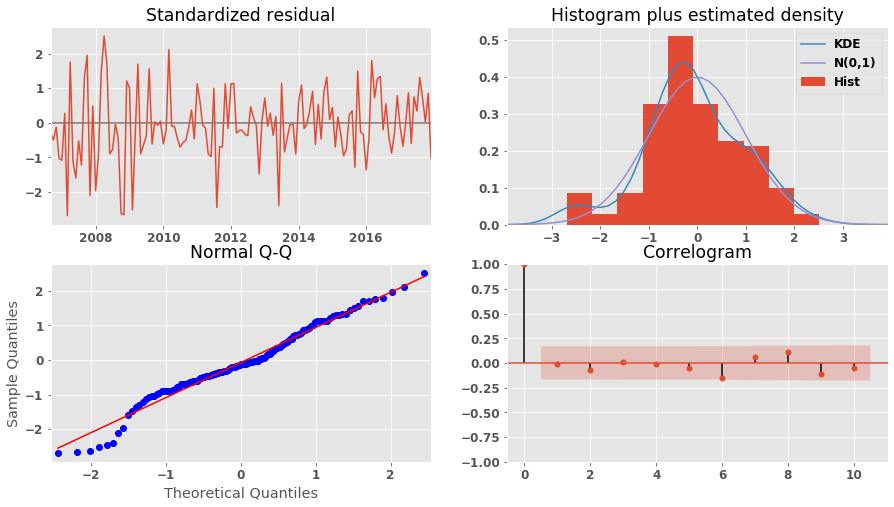

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


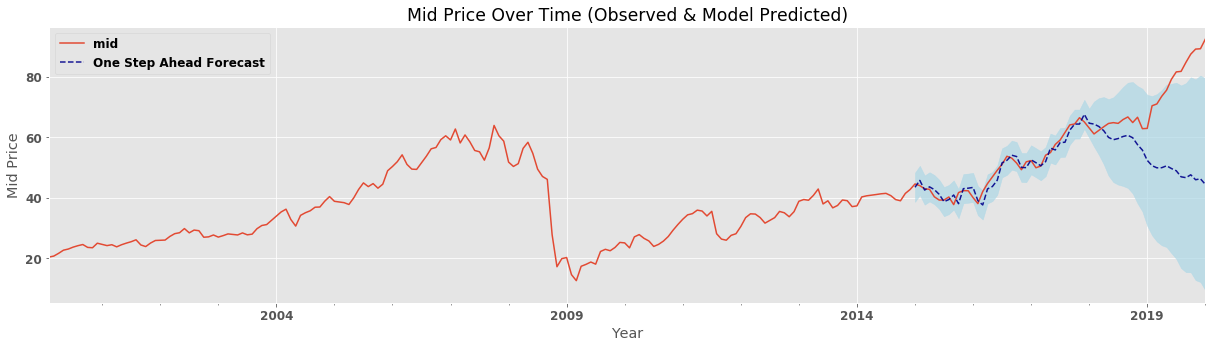

In [18]:
arima_exog(PLD_train, PLD, parameters, seasonal_parameters, exog_train, exog_test)